In [1]:
import torch,sys
sys.path.append('../')
import numpy as np
import torch.nn as nn
from torch.optim import Adam,SGD
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import DiceLoss, SquarePad,SquarePad255
from UNET_LIB.ACDC_Dataset import ACDC_Dataset
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from UNET_LIB.InceptionUnet import InceptionUNet
from LAIPAS_Images.LAIPAS_DATA import LAIPAS_Dataset

num_classes=4

# model = InceptionUNet(1,num_classes)
# teacher_net = InceptionUNet(1,num_classes)

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=False)
model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

teacher_net = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=False)
teacher_net.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
teacher_net.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    
with torch.no_grad():
    for ema_para,para in zip(teacher_net.parameters(),model.parameters()):
        ema_para.data = para.data

model = nn.DataParallel(model).cuda()
teacher_net = nn.DataParallel(teacher_net).cuda()

img_preprocess = transforms.Compose([    
#     SquarePad(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(0,1),
])

val_preprocess = transforms.Compose([    
#     SquarePad(),
    transforms.ToTensor(),
    transforms.Normalize(0,1),
])


msk_preprocess = transforms.Compose([])

epochs = 120
variant = '_pat_bal'
optim_spec = 'SGD'
weighted = ''
loss_spec = 'CE'
assert loss_spec in ['Dice', 'CE'] 
assert weighted in ['_weighted','']
model_name = f'DLab_LAIPAS_{variant}_o{optim_spec}{weighted}_MT'

train_size = 496
batch_size = 8
train_DATA = LAIPAS_Dataset('/data/LAIPAS_Images/', 'train'+variant, img_preprocess, msk_preprocess,crop_size=train_size)
val_DATA = LAIPAS_Dataset('/data/LAIPAS_Images/', 'val', val_preprocess, msk_preprocess,
                          rot = False, resize=False,crop_size = 1024,ignore=False)

unlabeled_DATA_train =  LAIPAS_Dataset('/data/LAIPAS_Images/', 'unlabeled'+variant, 
                                       img_preprocess, msk_preprocess,crop_size=train_size) 
unlabeled_DATA_val  = LAIPAS_Dataset('/data/LAIPAS_Images/', 'val', 
                                     img_preprocess, msk_preprocess,crop_size=train_size)

unlabeled_DATA = ConcatDataset([unlabeled_DATA_train,unlabeled_DATA_val])

loader_l = DataLoader(train_DATA, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=batch_size)
loader_u = DataLoader(unlabeled_DATA, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=batch_size)
val_loader = DataLoader(val_DATA, batch_size=batch_size//2, shuffle=True, drop_last=True, num_workers=batch_size)
u_iterator = iter(loader_u)


Using cache found in /home/yz696/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/yz696/.cache/torch/hub/pytorch_vision_v0.10.0


In [2]:
min_loss = np.inf
fin_epoch = 0
if optim_spec == 'AD':
    optimizer = Adam(model.parameters(),lr=1e-4,eps=0.1, weight_decay=1e-6)

elif optim_spec == 'SGDL':
    optimizer = SGD([{'params':model.module.backbone.parameters(), 'lr': 1e-2},
                     {'params': model.module.classifier.parameters(), 'lr': 1e-1},
                    ],momentum=0.9,weight_decay=1e-4)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[500*i for i in range(1,9)], gamma=0.8)
elif optim_spec == 'SGD':
    optimizer = SGD(model.parameters(),lr=5e-2,momentum=0.9,weight_decay=5e-4)

else:
    assert False

try:
        checkpoint = torch.load(f'/data/LAIPAS_Images/model_checkpoints/{model_name}.pth')
        fin_epoch = checkpoint['fin_epoch']
        min_loss = checkpoint['min_loss']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print('optimizer loaded')
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print('scheduler loaded')
except:
    if fin_epoch ==0:
        print(f'new model training {model_name}')

new model training DLab_LAIPAS__pat_bal_oSGD_MT


In [3]:
#methods follows MT and https://openreview.net/pdf?id=2o-qQu-mZa-
if loss_spec == 'Dice':
    ce_fn = DiceLoss() 
elif weighted == '':
    ce_fn = nn.CrossEntropyLoss(ignore_index=255)
else:
    ce_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='none')
    
mse_fn = nn.MSELoss()
softmax = nn.Softmax(dim=1)
min_loss = np.inf

iter_count=-1.
alpha = 0.99

pbar = tqdm(range(epochs-fin_epoch))
total_iter = epochs*len(loader_l)
for e in pbar:
    train_loss = 0
    val_loss = 0
    
    model.train()
    for idx,(X,y,w) in enumerate(loader_l):
        
        X_unlabeled, _ = next(u_iterator)
        iter_count += 1
        poly_rate = (1-iter_count/total_iter)**0.9
        if round(iter_count)%len(u_iterator) == len(u_iterator)-1:
            u_iterator = iter(loader_u)
        
        optimizer.zero_grad()
        if 'DLab' in model_name:
            yhat =  model(X.cuda().contiguous())['out']
            yhat_u= softmax(model(X_unlabeled.cuda().contiguous())['out'])
            
        else:
            yhat =  model(X.cuda().contiguous())
            yhat_u= softmax(model(X_unlabeled.cuda().contiguous()))
            
        with torch.no_grad():
            #update the mean teacher model
            alpha_ = min(1-1/(e+1), alpha)
            for ema_para, para in zip(teacher_net.parameters(), model.parameters()):
                ema_para.data = ema_para.data*alpha + para.data*(1-alpha_)
            
            if 'DLab' in model_name:
                y_unlabeled = softmax(teacher_net(X_unlabeled.cuda().contiguous())['out'])
            else:
                y_unlabeled = softmax(teacher_net(X_unlabeled.cuda().contiguous()))
            
        if loss_spec == 'CE' and weighted != '':
            loss = ((ce_fn(yhat,y.cuda())*w.cuda()).mean() + mse_fn(yhat_u,y_unlabeled))*poly_rate
        else:
            loss = (ce_fn(yhat,y.cuda()) + mse_fn(yhat_u,y_unlabeled))*poly_rate
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= (idx+1)
#     del X_unlabeled, _
#     torch.cuda.empty_cache()
    model.eval()
    with torch.no_grad():
        class_intersect = np.zeros((num_classes,),dtype='float')
        class_union= np.zeros((num_classes,),dtype='float')
        
        for idx,(X,y) in enumerate(val_loader):
            
            y = y.cuda().contiguous().flatten()
            if 'DLab' in model_name:
                yhat = model(X.contiguous().cuda())['out']
            else:
                yhat = model(X.contiguous().cuda())
            
            yhat_lab = torch.argmax(yhat, dim=1).flatten()

            for j in range(num_classes):

                y_bi = y == j
                yhat_bi = yhat_lab == j
                I = ((y_bi * yhat_bi).sum()).item()
                U = (y_bi.sum() + yhat_bi.sum() - I).item()
                assert I <= U
                class_intersect[j] += I
                class_union[j] += U

        IOUs = class_intersect/class_union
        val_loss=-np.mean(IOUs)
        pbar.set_description(f'Train loss: {train_loss}| IOU: {-val_loss}')
    
    if e +fin_epoch+1 <10:
        continue

    if val_loss < min_loss:
        min_loss = val_loss
        to_save ={
            'min_loss': min_loss,
            'fin_epoch': e+fin_epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}
        if optim_spec == 'SGDL':
            to_save['scheduler_state_dict']= scheduler.state_dict()

        torch.save(to_save, f'/data/LAIPAS_Images/model_checkpoints/{model_name}.pth')  
    

Train loss: 0.00030037501547715354| IOU: 0.6693223706870374: 100%|███████████████████████| 120/120 [4:41:20<00:00, 140.67s/it]


In [8]:
checkpoint = torch.load(f'/data/LAIPAS_Images/model_checkpoints/{model_name}.pth')
fin_epoch = checkpoint['fin_epoch']
min_loss = checkpoint['min_loss']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
IOUs

array([0.73079046, 0.81408273, 0.72869656, 0.40371973])

In [17]:
pred = []
orig = []
img_ = []
model.eval()
with torch.no_grad():
    class_intersect = np.zeros((num_classes,),dtype='float')
    class_union= np.zeros((num_classes,),dtype='float')
    for idx,(X,y) in enumerate(val_loader):
        y = y.cuda().contiguous()
        orig.append(y)
        img_.append(X)
        if 'DLab' not in model_name:
            yhat = model(X.contiguous().cuda())
        else:
            yhat = model(X.contiguous().cuda())['out']
        yhat_lab = torch.argmax(yhat, dim=1)
        for j in range(num_classes):

            y_bi = y == j
            yhat_bi = yhat_lab == j
            I = ((y_bi * yhat_bi).sum()).item()
            U = (y_bi.sum() + yhat_bi.sum() - I).item()
            assert I <= U
            class_intersect[j] += I
            class_union[j] += U
            
        pred.append(yhat_lab)
    yhat_lab = torch.cat(pred)
    y = torch.cat(orig)
    X = torch.cat(img_)
        

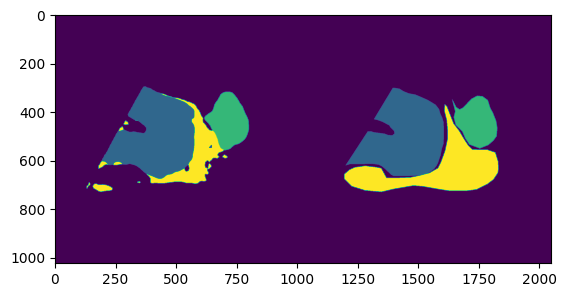

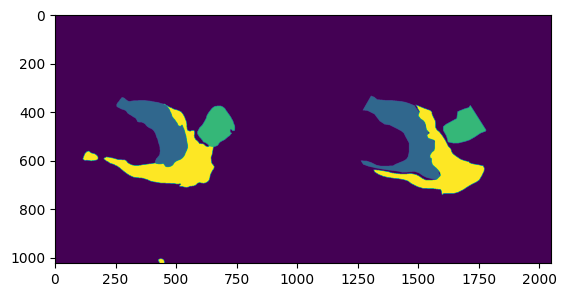

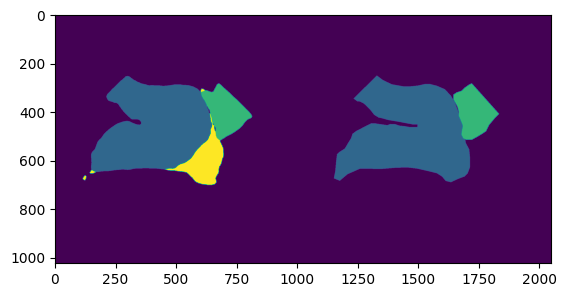

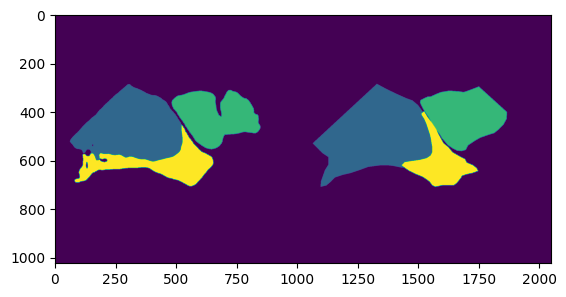

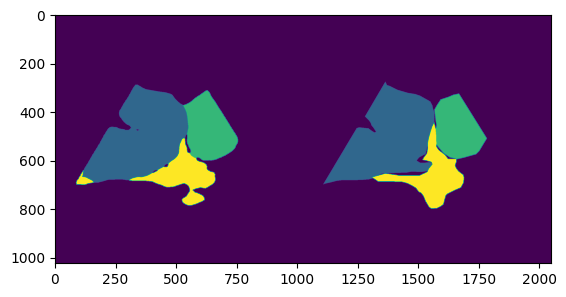

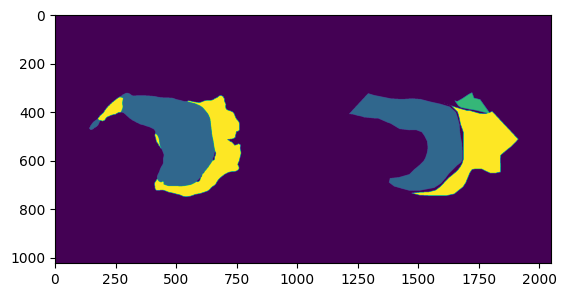

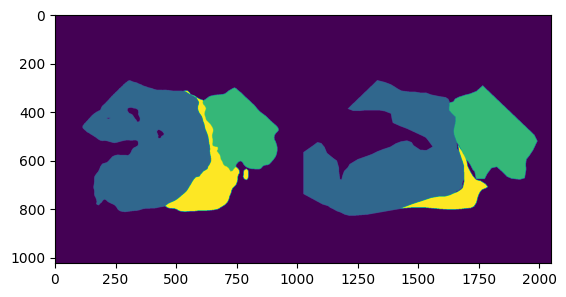

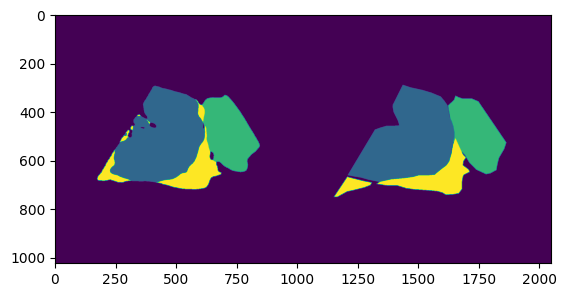

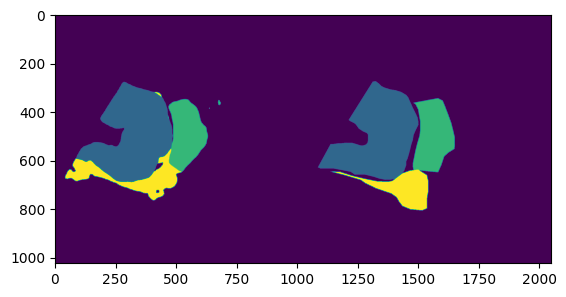

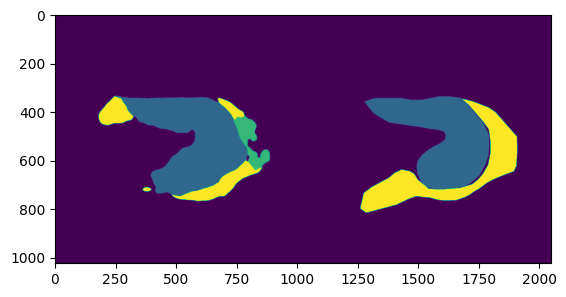

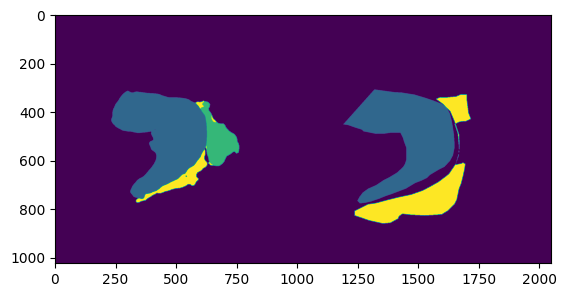

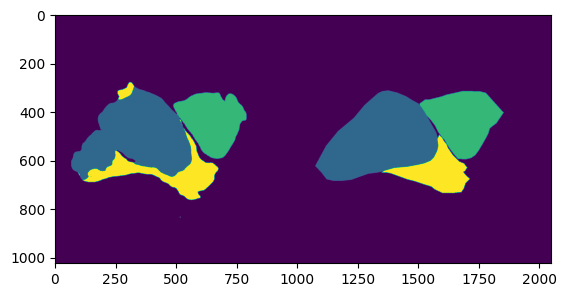

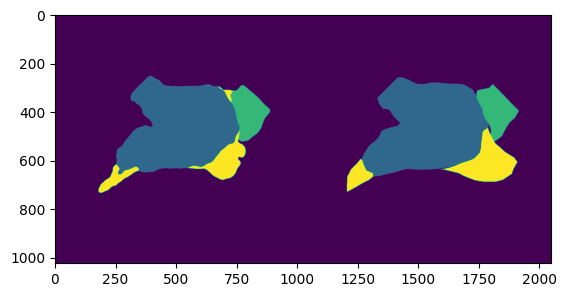

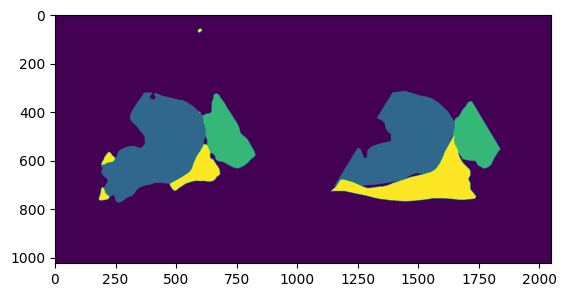

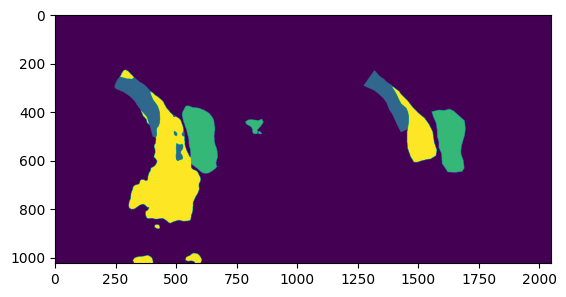

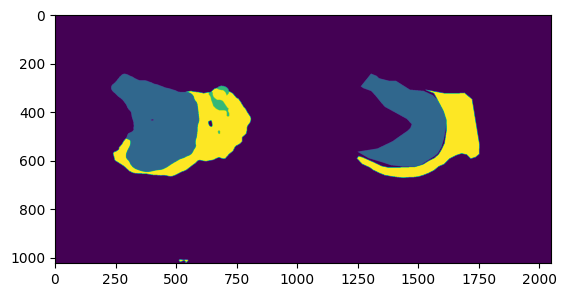

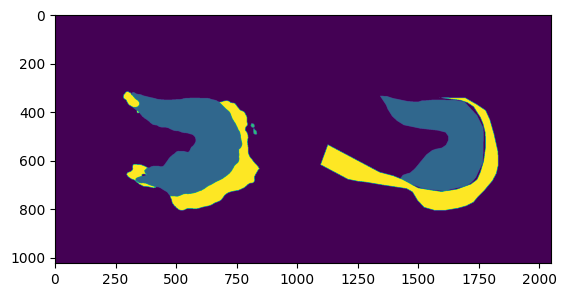

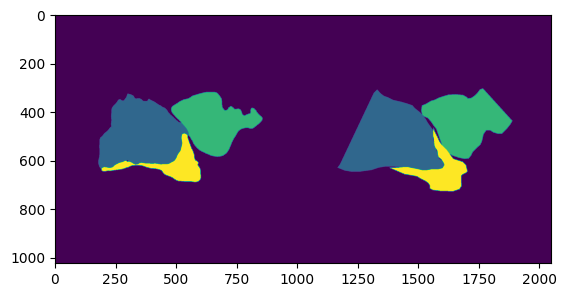

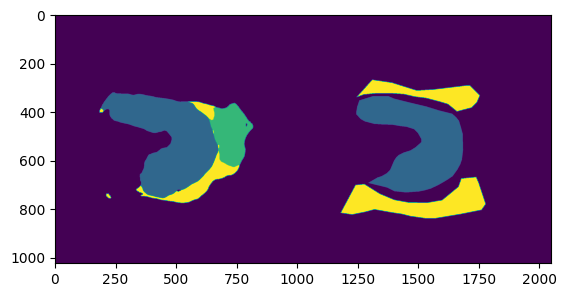

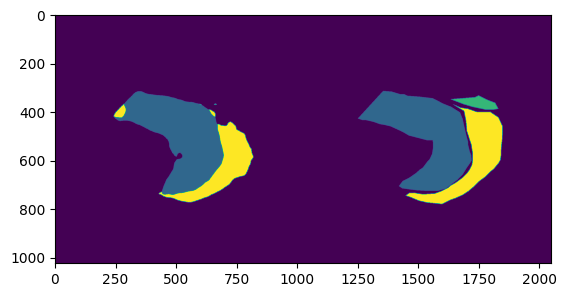

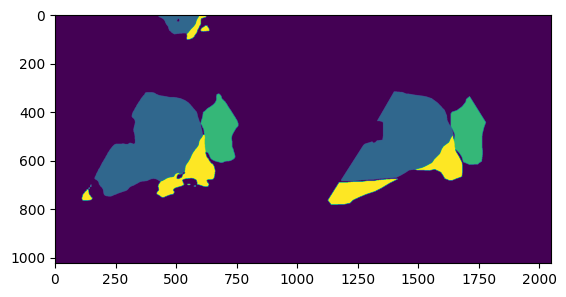

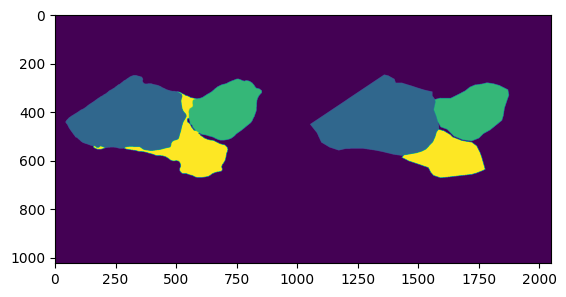

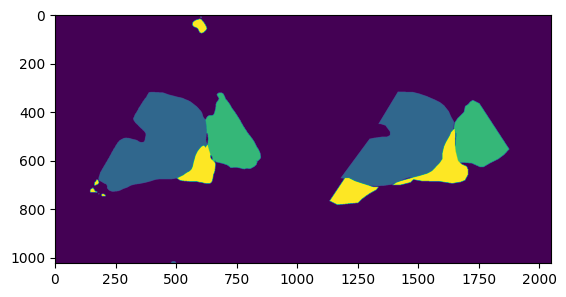

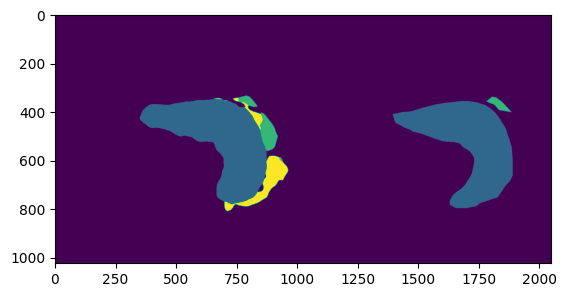

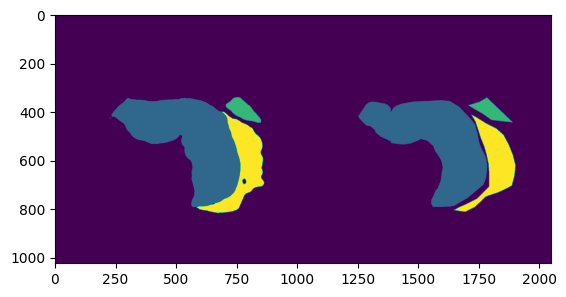

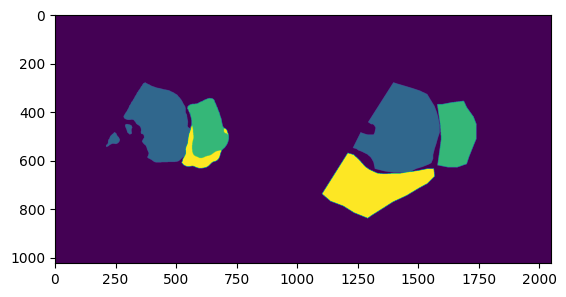

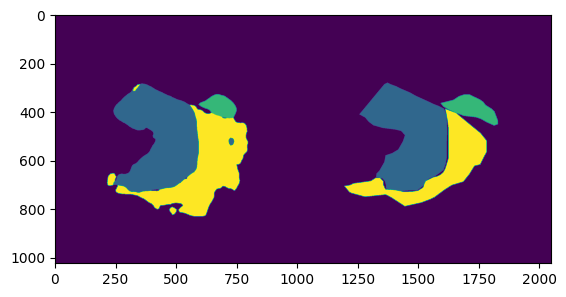

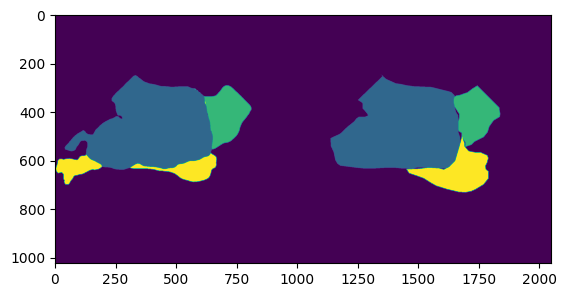

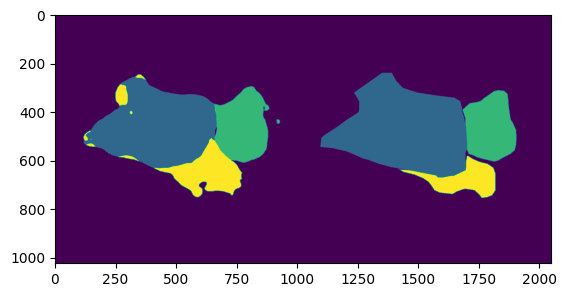

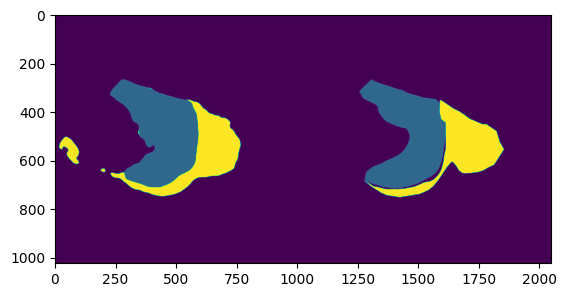

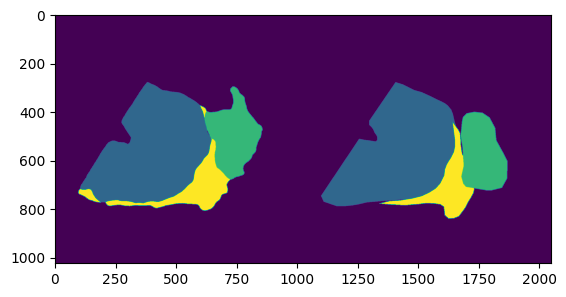

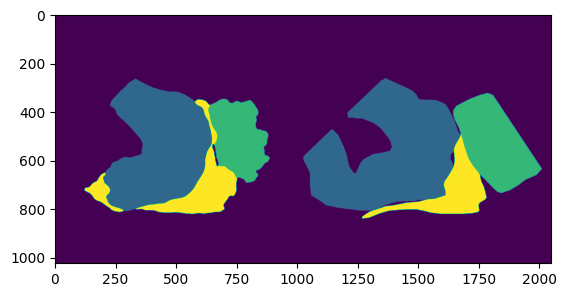

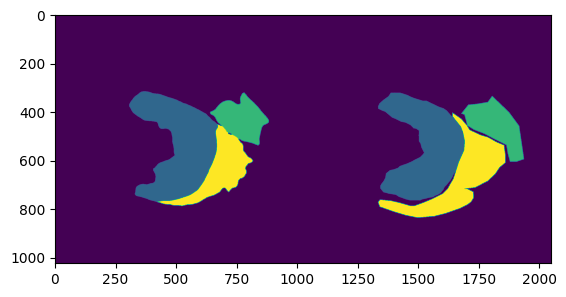

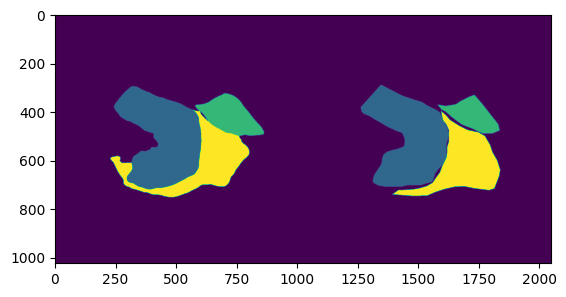

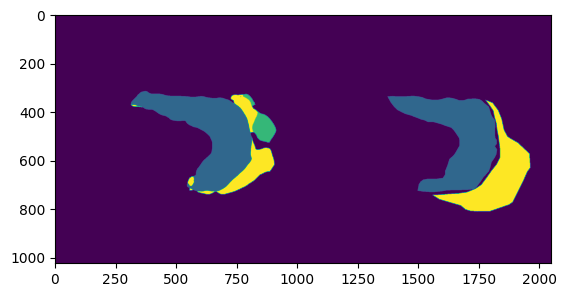

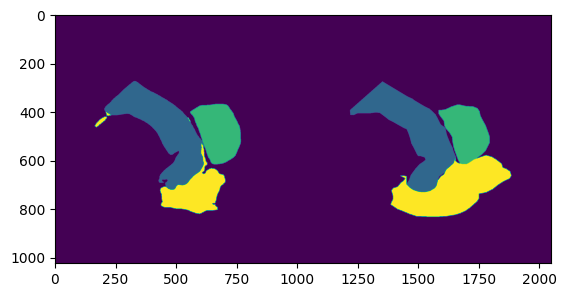

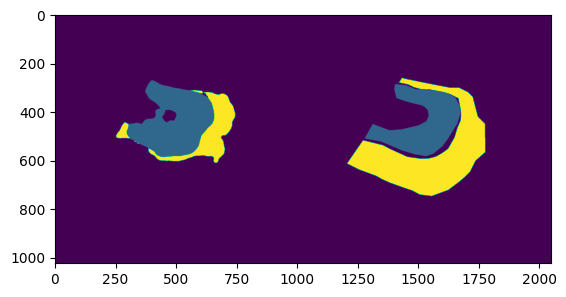

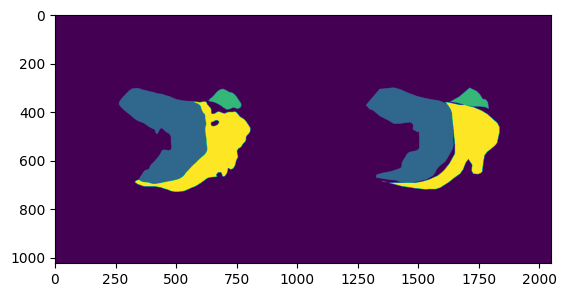

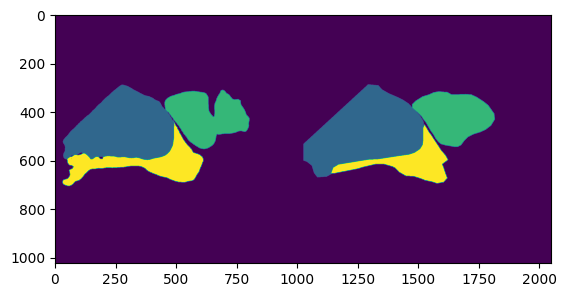

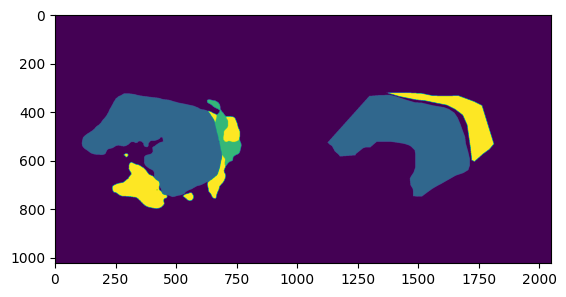

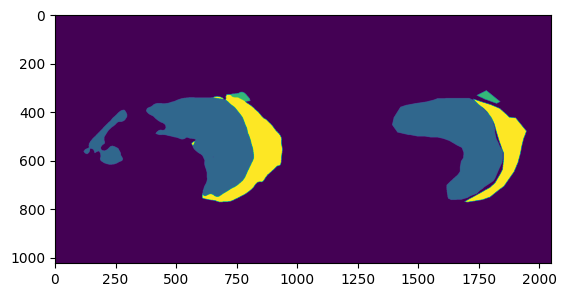

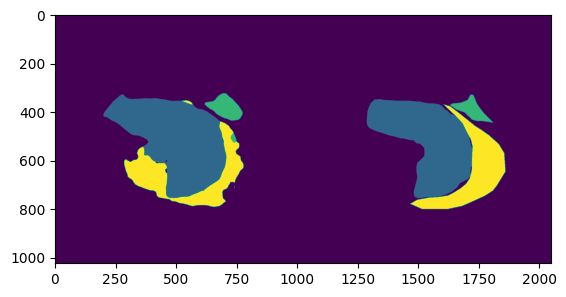

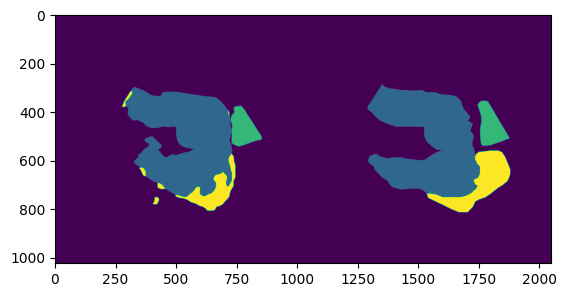

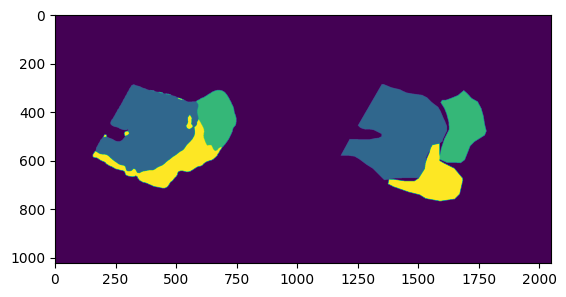

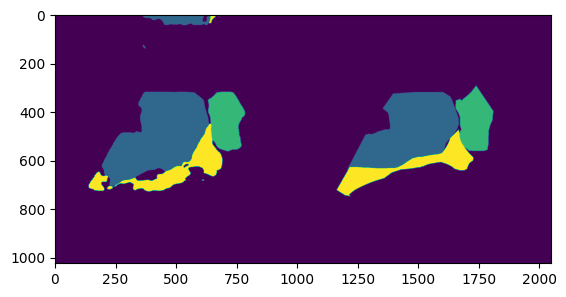

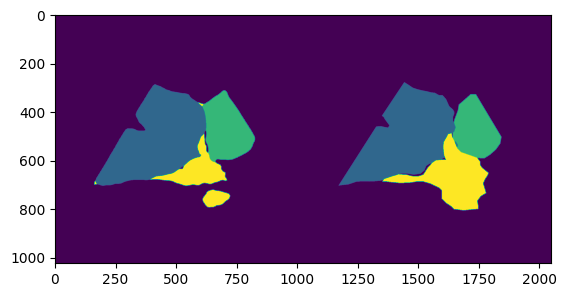

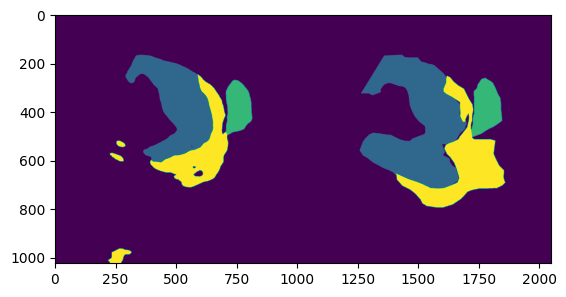

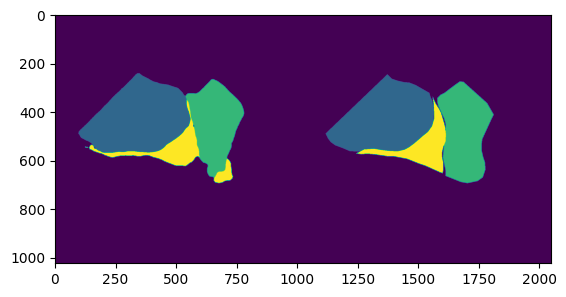

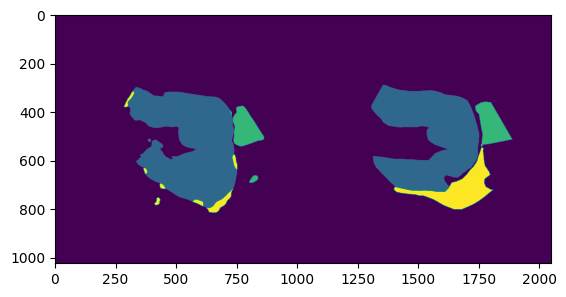

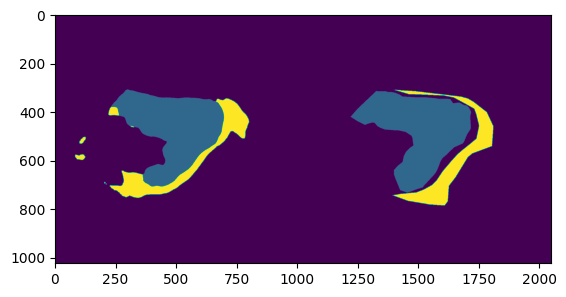

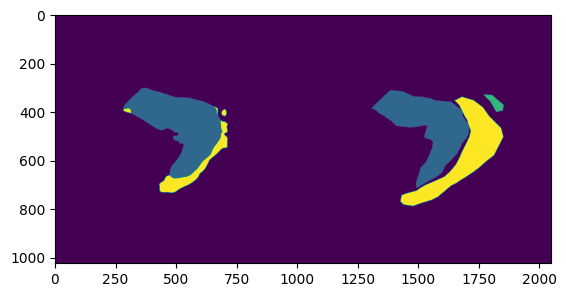

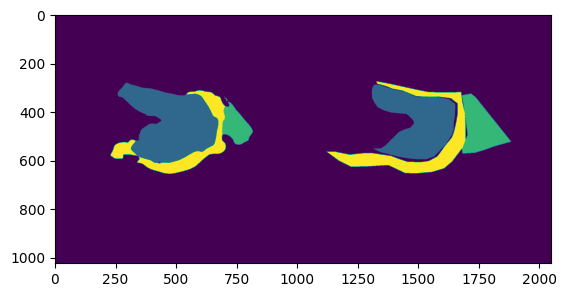

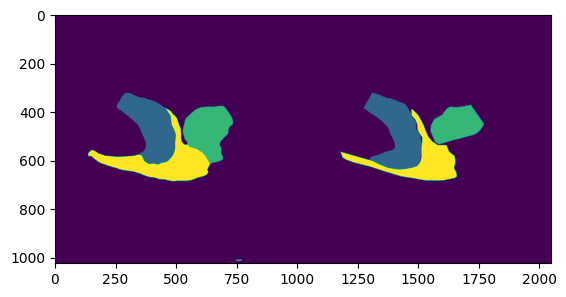

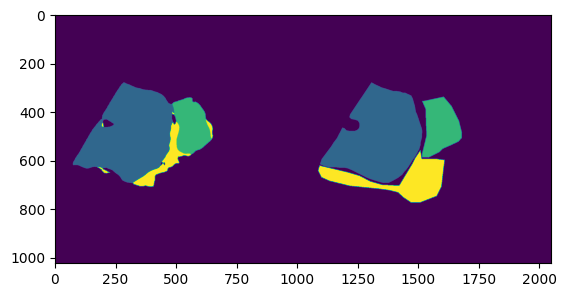

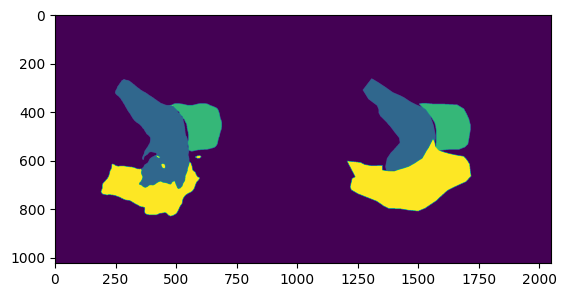

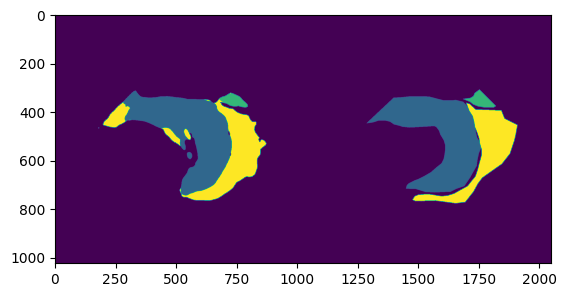

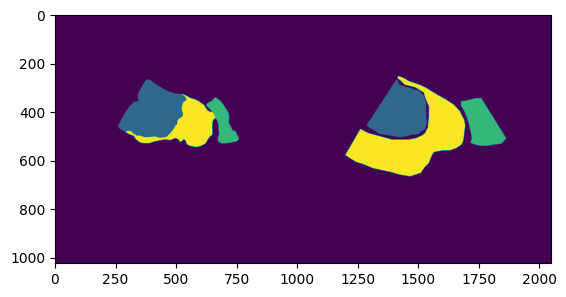

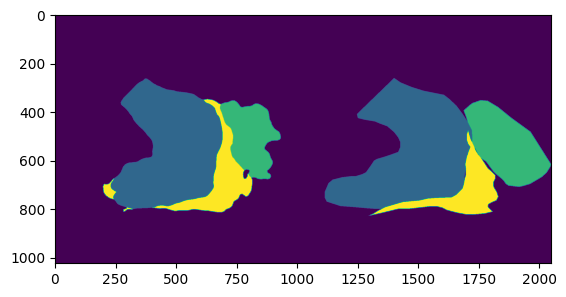

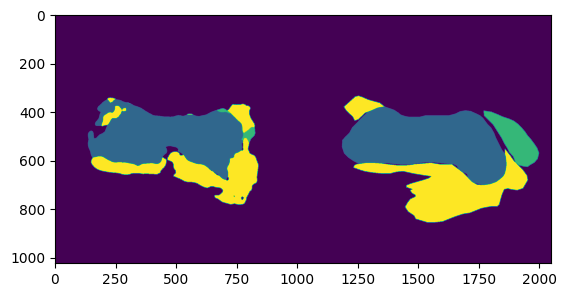

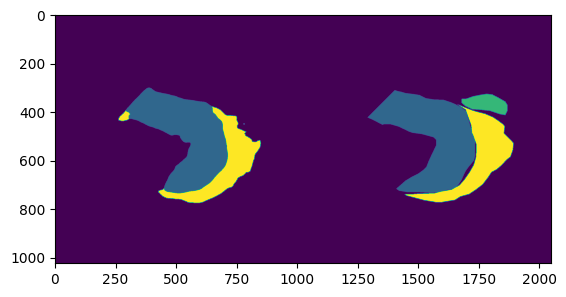

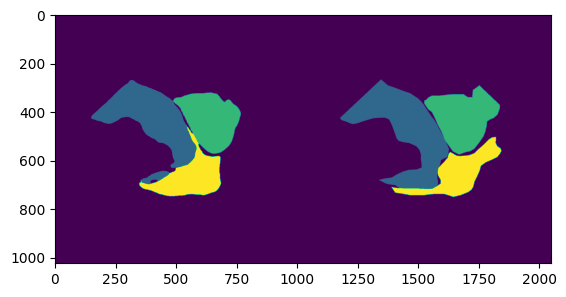

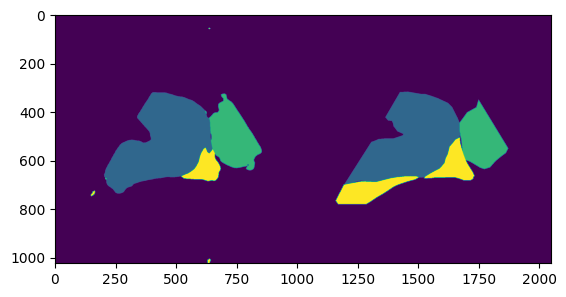

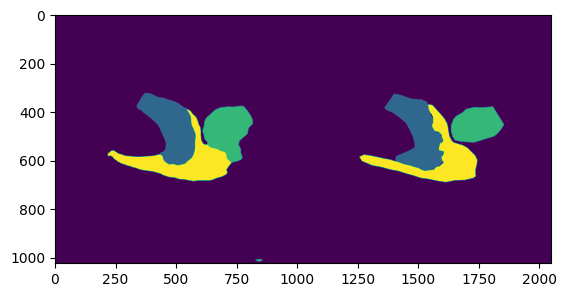

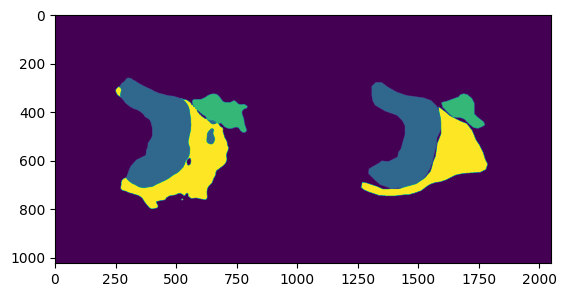

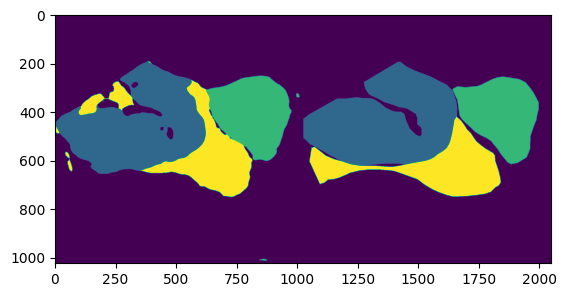

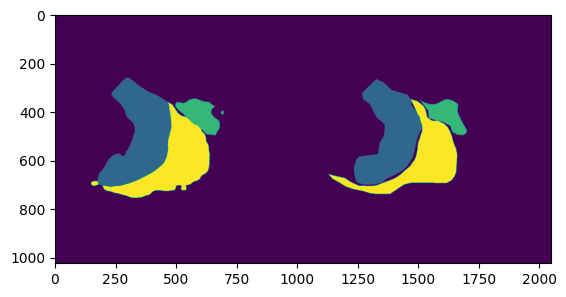

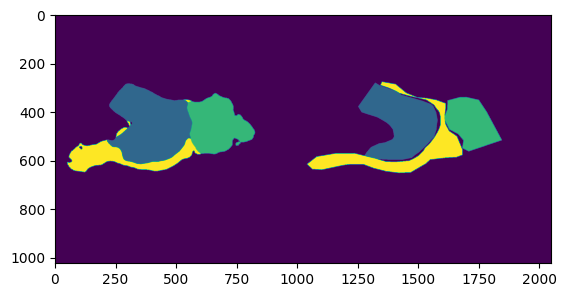

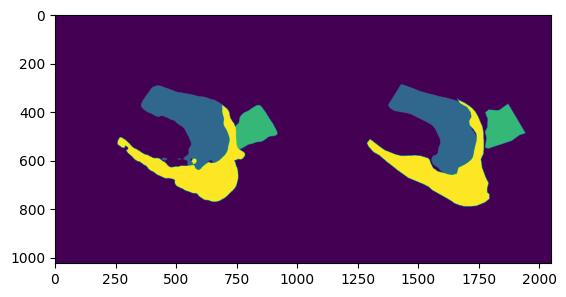

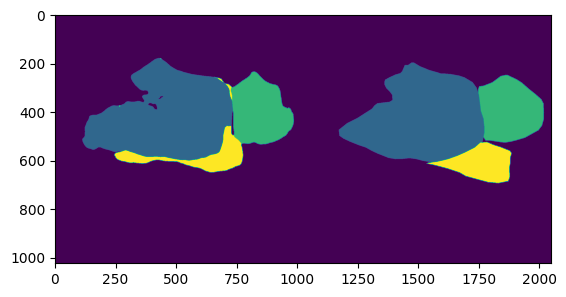

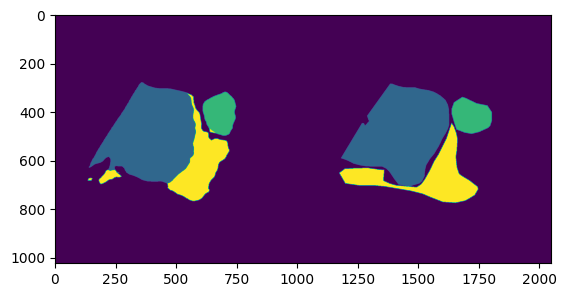

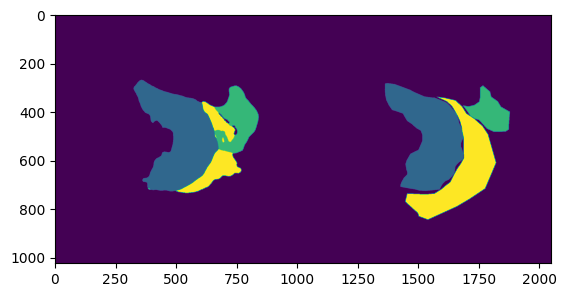

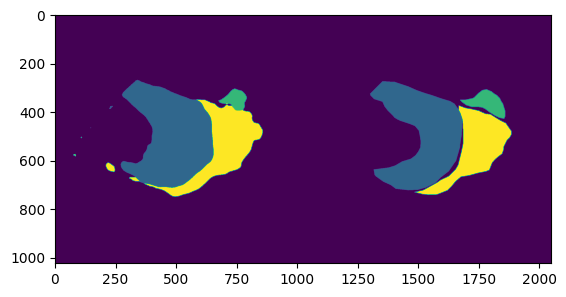

In [19]:
for _ylab,_y in zip(yhat_lab.cpu(),y.cpu()):
    _y[_y==255]=0
    plt.imshow(torch.cat([_ylab,_y],axis=1))
    plt.show()

In [12]:
IOUs

array([0.72557729, 0.76081925, 0.6459857 , 0.37062486])

In [4]:
IOUs

array([0.72930868, 0.77119344, 0.66577101, 0.36104516])